In [145]:
notebook_mode = True
viz_mode = False

In [160]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    print("CUDA is available. GPU can be used.")
    print("Number of GPUs available:", torch.cuda.device_count())
    print("Current GPU device:", torch.cuda.current_device())
    print("GPU name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available. GPU cannot be used.")


CUDA is not available. GPU cannot be used.


# Import packages

In [172]:
import os
import json
import argparse
import time
import random

import numpy as np
import csv

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter  # tensorboardXの代替

import matplotlib
import matplotlib.pyplot as plt

import networkx as nx
from sklearn.utils.class_weight import compute_class_weight

from fastprogress import master_bar, progress_bar

# Remove warning
import warnings
#warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter("ignore")
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore', SparseEfficiencyWarning)

from config import *
from utils.graph_utils import *
from utils.exact_solution import SolveExactSolution
from utils.flow import Flow
from utils.data_maker import DataMaker
from utils.dataset_reader import DatasetReader
from utils.plot_utils import *
from models.gcn_model import ResidualGatedGCNModel
from utils.model_utils import *

# Setting for notebook

In [162]:
if notebook_mode == True:
    %load_ext autoreload
    %autoreload 2
    %matplotlib inline
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('png')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load configurations

In [178]:
config_path = "configs/default.json"

config = get_config(config_path)
print("Loaded {}:\n{}".format(config_path, config))

Loaded configs/default.json:
{'expt_name': 'deafult', 'gpu_id': '0', 'graph_filepath': './data/graph.gml', 'edge_numbering_filepath': './data/edge_numbering_file.csv', 'train_filepath': './data/gragh.gml', 'val_filepath': './data/tsp10_val_concorde.txt', 'test_filepath': './data/tsp10_test_concorde.txt', 'solver_type': 'pulp', 'graph_model': 'nsfnet', 'num_train_data': 160, 'num_test_data': 20, 'num_val_data': 20, 'num_nodes': 14, 'num_neighbors': 5, 'num_commodities': 10, 'sample_size': 5, 'capacity_lower': 500, 'capacity_higher': 1000, 'demand_lower': 1, 'demand_higher': 500, 'node_dim': 10, 'voc_nodes_in': 2, 'voc_nodes_out': 2, 'voc_edges_in': 3, 'voc_edges_out': 10, 'beam_size': 10, 'hidden_dim': 50, 'num_layers': 3, 'mlp_layers': 2, 'aggregation': 'mean', 'max_epochs': 10, 'val_every': 5, 'test_every': 10, 'batch_size': 20, 'batches_per_epoch': 500, 'accumulation_steps': 1, 'learning_rate': 0.001, 'decay_rate': 1.01}


# Configure GPU options

In [177]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(config.gpu_id) 

if torch.cuda.is_available():
    print("CUDA available, using GPU ID {}".format(config.gpu_id))
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(1)
else:
    print("CUDA not available")
    dtypeFloat = torch.float
    dtypeLong = torch.long
    torch.manual_seed(1)

CUDA not available


# Make graph dataset
gragh.gmlとedge_numbering_file.csvの作成

In [182]:
#　choose train, val and test
data_mode = "test"
num_data = getattr(config, f'num_{data_mode}_data')
solver_type = config.solver_type
Maker = DataMaker(config)
exact_file_name ="./data/{}_data/exact_solution.csv".format(data_mode)
infinit_loop_count = 0
incorrect_value_count = 0

for data in range(num_data):
    if data % 10 == 0:
        print(data, " data was created.")
    # ディレクトリ番号の定義
    file_number = data - (data % 10)
    
    # ディレクトリの作成
    graph_file_directory = "./data/{data_mode}_data/graph_file/{file_number}".format(data_mode=data_mode, file_number=file_number)
    if not os.path.exists(graph_file_directory):
        os.makedirs(graph_file_directory)
    commodity_file_directory = "./data/{data_mode}_data/commodity_file/{file_number}".format(data_mode=data_mode, file_number=file_number)
    if not os.path.exists(commodity_file_directory):
        os.makedirs(commodity_file_directory)
    edge_file_directory = "./data/{data_mode}_data/edge_file/{file_number}".format(data_mode=data_mode, file_number=file_number)
    if not os.path.exists(edge_file_directory):
        os.makedirs(edge_file_directory)
    node_flow_file_directory = "./data/{data_mode}_data/node_flow_file/{file_number}".format(data_mode=data_mode, file_number=file_number)
    if not os.path.exists(node_flow_file_directory):
        os.makedirs(node_flow_file_directory)
    edge_flow_file_directory = "./data/{data_mode}_data/edge_flow_file/{file_number}".format(data_mode=data_mode, file_number=file_number)
    if not os.path.exists(edge_flow_file_directory):
        os.makedirs(edge_flow_file_directory)

    # ファイル名の定義
    graph_file_name = "./data/{data_mode}_data/graph_file/{file_number}/graph_{data}.gml".format(data_mode=data_mode, file_number=file_number, data=data)
    comodity_file_name = "./data/{data_mode}_data/commodity_file/{file_number}/commodity_data_{data}.csv".format(data_mode=data_mode, file_number=file_number, data=data)
    edge_file_name = "./data/{data_mode}_data/edge_file/{file_number}/edge_numbering_{data}.csv".format(data_mode=data_mode, file_number=file_number, data=data)
    node_flow_file_name = "./data/{data_mode}_data/node_flow_file/{file_number}/node_flow_{data}.csv".format(data_mode=data_mode, file_number=file_number, data=data)
    edge_flow_file_name = "./data/{data_mode}_data/edge_flow_file/{file_number}/edge_flow_{data}.csv".format(data_mode=data_mode, file_number=file_number, data=data)

    # 作成したdataが適切で無い場合のやり直し
    while True:
    # グラフ作成
        G = Maker.create_graph()
        
        # 品種作成
        commodity_list = Maker.generate_commodity()
        
        # グラフの保存
        nx.write_gml(G, graph_file_name)

        # 品種の保存
        with open((comodity_file_name), 'w') as f:
            writer = csv.writer(f, lineterminator='\n')
            writer.writerows(commodity_list)

        # 厳密解の計算
        E = SolveExactSolution(solver_type, comodity_file_name, graph_file_name)
        flow_var_kakai, edge_list, objective_value, elapsed_time = E.solve_exact_solution_to_env()
        node_flow_matrix, edge_flow_matrix, infinit_loop = E.generate_flow_matrices(flow_var_kakai)
        
        # 厳密解が1以上、または厳密解のフローが正しく導けなかった場合のやり直し
        if infinit_loop:
            infinit_loop_count += 1
        elif objective_value >= 1.0:
            incorrect_value_count += 1
        else:
            break
    
    # エッジの保存
    with open(edge_file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        for item in edge_list:
            writer.writerow([item[0], item[1][0], item[1][1]])
    
    # 厳密解の保存
    with open(exact_file_name, 'a', newline='') as f:
        out = csv.writer(f)
        out.writerow([objective_value,elapsed_time]) 

    # 厳密解のノードのフローの保存
    with open(node_flow_file_name, mode="w", newline="") as file:
        writer = csv.writer(file)
        for row in node_flow_matrix:
            writer.writerow(row)
    # 厳密解のエッジのフローの保存
    with open(edge_flow_file_name, mode="w", newline="") as file:
        writer = csv.writer(file)
        for row in edge_flow_matrix:
            writer.writerow(row)


0  data was created.
10  data was created.


# Test data loading

Number of batches of size 20: 1
Batch generation took: 0.077 sec
edges shape: (20, 14, 14)
edges: [[0 1 1 0 0 0 0 1 0 0 0 0 0 0]
 [1 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 1 1 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 1 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 1 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 1 0 1 0 1 0]
 [0 0 0 0 0 1 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 1 0 1 0 1 0]]
edges_capacity shape: (20, 14, 14)
edges_capacity: [[  0. 693. 548.   0.   0.   0.   0. 690.   0.   0.   0.   0.   0.   0.]
 [693.   0. 942. 685.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [548. 942.   0.   0.   0. 882.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 685.   0.   0. 942.   0.   0.   0.   0.   0. 571.   0.   0.   0.]
 [  0.   0.   0. 942.   0. 828. 715.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 882.   0. 828.   0.   0.   0.   0. 961.

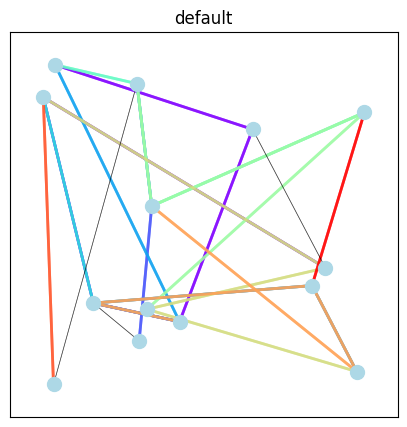

In [183]:
if notebook_mode:
    mode = "test"
    num_data = getattr(config, f'num_{data_mode}_data')
    batch_size = config.batch_size
    #　DataMakerを繰り返し呼び出しバッチごとにtensorを生成する
    dataset = DatasetReader(num_data, batch_size, mode)
    print("Number of batches of size {}: {}".format(batch_size, dataset.max_iter))

    t = time.time()
    
    idx = 0
    batch = next(iter(dataset))  # Generate a batch of TSPs
    print("Batch generation took: {:.3f} sec".format(time.time() - t))
    print("edges shape:", batch.edges.shape)
    print("edges:", batch.edges[idx])
    print("edges_capacity shape:", batch.edges_capacity.shape)
    print("edges_capacity:", batch.edges_capacity[idx])
    print("edges_targets shape:", batch.edges_target.shape)
    print("edges_targets:", batch.edges_target[idx, :, :, idx])
    print("nodes shape:", batch.nodes.shape)
    print("nodes:", batch.nodes[idx])
    print("nodes_target shape:", batch.nodes_target.shape)
    print("nodes_target:", batch.nodes_target[idx])
    print("commodities shape:", batch.commodities.shape)
    print("commodities:", batch.commodities[idx])
    print("load_factor shape:", batch.load_factor.shape)
    
    f = plt.figure(figsize=(5, 5))
    a = f.add_subplot(111)
    plot_uelb(a, batch.edges[idx], batch.edges_target[idx])

# Instantiate model

In [153]:
if notebook_mode == True:
    # Instantiate the network
    net = nn.DataParallel(ResidualGatedGCNModel(config, dtypeFloat, dtypeLong))
    if torch.cuda.is_available():
        net.cuda()
    print(net)

    # Compute number of network parameters
    nb_param = 0
    for param in net.parameters():
        nb_param += np.prod(list(param.data.size()))
    print('Number of parameters:', nb_param)
    
    # Define optimizer
    learning_rate = config.learning_rate
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    print(optimizer)

    # Enable anomaly detection
    torch.autograd.set_detect_anomaly(True)

DataParallel(
  (module): ResidualGatedGCNModel(
    (nodes_commodity_embedding): Linear(in_features=10, out_features=50, bias=False)
    (edges_values_embedding): Linear(in_features=1, out_features=50, bias=False)
    (gcn_layers): ModuleList(
      (0-2): 3 x ResidualGatedGCNLayer(
        (node_feat): NodeFeatures(
          (U): Linear(in_features=50, out_features=50, bias=True)
          (V): Linear(in_features=50, out_features=50, bias=True)
        )
        (edge_feat): EdgeFeatures(
          (U): Linear(in_features=50, out_features=50, bias=True)
          (V): Linear(in_features=50, out_features=50, bias=True)
        )
        (bn_node): BatchNormNode(
          (batch_norm): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
        (bn_edge): BatchNormEdge(
          (batch_norm): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
        (relu): ReLU(inplace=True)
      )
    )
    (mlp_edges

# Test forward pass

In [189]:
if notebook_mode == True and viz_mode == False:
    # Generate a batch of UELBs
    mode = "train"
    num_data = getattr(config, f'num_{data_mode}_data')
    batch_size = config.batch_size
    train_filepath = config.train_filepath
    dataset = iter(DatasetReader(num_data, batch_size, mode))
    batch = next(dataset)

    # Convert batch to torch Variables
    x_edges = torch.LongTensor(batch.edges).to(torch.long).contiguous().requires_grad_(False)
    x_edges_capacity = torch.FloatTensor(batch.edges_capacity).to(torch.float).contiguous().requires_grad_(False)
    x_nodes = torch.FloatTensor(batch.nodes).to(torch.float).contiguous().requires_grad_(False)
    y_edges = torch.LongTensor(batch.edges_target).to(torch.long).contiguous().requires_grad_(False)
    y_nodes = torch.LongTensor(batch.nodes_target).to(torch.long).contiguous().requires_grad_(False)
    batch_commodities = torch.LongTensor(batch.commodities).to(torch.long).contiguous().requires_grad_(False)
    
    # Compute class weights
    edge_labels = y_edges.cpu().numpy().flatten()
    edge_cw = create_edge_class_weights(y_edges)
    print("Class weights: {}".format(edge_cw))
        
    # Enable anomaly detection
    torch.autograd.set_detect_anomaly(True)

    # Forward pass
    y_preds, loss = net.forward(x_edges, x_edges_capacity, x_nodes, y_edges, edge_cw)
    loss = loss.mean()
    print("Output size: {}".format(y_preds.size()))
    print("Output: {}".format(y_preds[0, :, :, 0]))
    print("Loss value:", loss)

Class weights: tensor([ 0.5148, 17.4067])
Output size: torch.Size([20, 14, 14, 10])
Output: tensor([[-1.3482e-01, -6.3125e+01, -4.2299e+01, -3.8344e-02, -9.0635e-03,
         -1.9232e-02,  2.1204e-01, -5.6408e+01, -1.5539e-01, -1.2396e-02,
         -1.9492e-02, -3.5545e-03,  1.4140e-01, -3.3745e-01],
        [-6.3125e+01, -8.2614e-02, -4.2262e+01, -3.9354e+01, -3.3351e-02,
         -8.2450e-02, -1.7219e-02, -8.5898e-02, -5.8721e-02, -4.7454e-02,
         -8.2229e-02, -3.8096e-02,  8.2528e-02, -2.5886e-01],
        [-4.2299e+01, -4.2262e+01,  1.0149e-01,  8.4095e-03, -7.0457e-02,
         -4.4822e+01,  1.3116e-01, -8.3258e-02, -1.4179e-01,  4.2951e-02,
          2.2738e-02,  9.9284e-02,  2.1984e-01, -2.2300e-01],
        [-3.8344e-02, -3.9354e+01,  8.4095e-03, -1.2002e-01, -4.4059e+01,
         -9.9821e-02, -4.8210e-03, -1.0287e-01, -8.3325e-02, -6.9853e-02,
         -4.4193e+01, -4.4776e-02,  7.6246e-02, -2.5595e-01],
        [-9.0636e-03, -3.3351e-02, -7.0457e-02, -4.4059e+01,  1.9838

# Test backward pass

In [185]:
if notebook_mode == True and viz_mode == False:
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    
    # Optimizer step
    optimizer.step()
    
    # Compute error metrics 
    err_edges, err_flow, err_uelb, tour_err_idx, tsp_err_idx = edge_error(y_preds, y_edges, x_edges)
    print("Edge error: {:.3f}\nFlow error: {:.3f}\nUELB error: {:.3f}".format(err_edges, err_flow, err_uelb))
    
    # Compute mean predicted and groundtruth tour length
    mean_maximum_load_factor = mean_load_factor(x_edges_capacity, y_preds, x_edges, batch_commodities)
    gt_load_factor = np.mean(batch.load_factor) 
    print("Predicted load factor(Not always a feasible solution): {:.3f}\nGroundtruth load factor: {:.3f}".format(mean_maximum_load_factor, gt_load_factor))

Edge error: 58.167
Flow error: 40.000
UELB error: 93.441
Predicted load factor(Not always a feasible solution): 2.478
Groundtruth load factor: 0.631


# Training Loop (one epoch)

In [186]:
def train_one_epoch(net, optimizer, config, master_bar):
    # Set training mode
    net.train()

    # Assign parameters
    mode = "train"
    num_data = getattr(config, f'num_{data_mode}_data')
    batch_size = config.batch_size
    batches_per_epoch = config.batches_per_epoch
    accumulation_steps = config.accumulation_steps
    
    # Load UELB data
    dataset = DatasetReader(num_data, batch_size, mode)
    if batches_per_epoch != -1:
        batches_per_epoch = min(batches_per_epoch, dataset.max_iter)
    else:
        batches_per_epoch = dataset.max_iter

    # Convert dataset to iterable
    dataset = iter(dataset)
    
    # Initially set loss class weights as None
    edge_cw = None

    # Initialize running data
    running_loss = 0.0
    # running_err_edges = 0.0
    # running_err_tour = 0.0
    # running_err_tsp = 0.0
    running_mean_maximum_load_factor = 0.0
    running_gt_load_factor = 0.0
    running_nb_data = 0
    running_nb_batch = 0

    start_epoch = time.time()
    for batch_num in progress_bar(range(batches_per_epoch), parent=master_bar):
        # Generate a batch of TSPs
        try:
            batch = next(dataset)
        except StopIteration:
            break

        # Convert batch to torch Variables
        x_edges = torch.LongTensor(batch.edges).to(torch.long).contiguous().requires_grad_(False)
        x_edges_capacity = torch.FloatTensor(batch.edges_capacity).to(torch.float).contiguous().requires_grad_(False)
        x_nodes = torch.FloatTensor(batch.nodes).to(torch.float).contiguous().requires_grad_(False)
        y_edges = torch.LongTensor(batch.edges_target).to(torch.long).contiguous().requires_grad_(False)
        y_nodes = torch.LongTensor(batch.nodes_target).to(torch.long).contiguous().requires_grad_(False)
        batch_commodities = torch.LongTensor(batch.commodities).to(torch.long).contiguous().requires_grad_(False)
        
        # Compute class weights (if uncomputed)
        if type(edge_cw) != torch.Tensor:
            edge_labels = y_edges.cpu().numpy().flatten()
            edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
        
        # Forward pass
        y_preds, loss = net.forward(x_edges, x_edges_capacity, x_nodes, y_edges, edge_cw)
        loss = loss.mean()  # Take mean of loss across multiple GPUs
        loss = loss / accumulation_steps  # Scale loss by accumulation steps
        loss.backward()

        # Backward pass
        if (batch_num+1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # Compute error metrics and mean load factor
        # err_edges, err_tour, err_tsp, tour_err_idx, tsp_err_idx = edge_error(y_preds, y_edges, x_edges)
        mean_maximum_load_factor = mean_load_factor(x_edges_capacity, y_preds, x_edges, batch_commodities)
        gt_load_factor = np.mean(batch.load_factor) 

        # Update running data
        running_nb_data += batch_size
        running_loss += batch_size* loss.data.item()* accumulation_steps  # Re-scale loss
        # running_err_edges += batch_size* err_edges
        # running_err_tour += batch_size* err_tour
        # running_err_tsp += batch_size* err_tsp
        running_mean_maximum_load_factor += batch_size* mean_maximum_load_factor
        running_gt_load_factor += batch_size* gt_load_factor
        running_nb_batch += 1
        
        # Log intermediate statistics
        result = ('loss:{loss:.4f} mean_maximum_load_factor:{mean_maximum_load_factor:.3f} gt_load_factor:{gt_load_factor:.3f}'.format(
            loss=running_loss/running_nb_data,
            mean_maximum_load_factor=running_mean_maximum_load_factor/running_nb_data,
            gt_load_factor=running_gt_load_factor/running_nb_data))
        master_bar.child.comment = result

    # Compute statistics for full epoch
    loss = running_loss/ running_nb_data
    err_edges = 0 # running_err_edges/ running_nb_data
    err_tour = 0 # running_err_tour/ running_nb_data
    err_tsp = 0 # running_err_tsp/ running_nb_data
    mean_maximum_load_factor = running_mean_maximum_load_factor/ running_nb_data
    gt_load_factor = running_gt_load_factor/ running_nb_data

    return time.time()-start_epoch, loss, err_edges, err_tour, err_tsp, mean_maximum_load_factor, gt_load_factor


def metrics_to_str(epoch, time, learning_rate, loss, err_edges, err_tour, err_tsp, mean_maximum_load_factor, gt_load_factor):
    result = ( 'epoch:{epoch:0>2d}\t'
               'time:{time:.1f}h\t'
               'lr:{learning_rate:.2e}\t'
               'loss:{loss:.4f}\t'
               # 'err_edges:{err_edges:.2f}\t'
               # 'err_tour:{err_tour:.2f}\t'
               # 'err_tsp:{err_tsp:.2f}\t'
               'mean_maximum_load_factor:{mean_maximum_load_factor:.3f}\t'
               'gt_load_factor:{gt_load_factor:.3f}'.format(
                   epoch=epoch,
                   time=time/3600,
                   learning_rate=learning_rate,
                   loss=loss,
                   # err_edges=err_edges,
                   # err_tour=err_tour,
                   # err_tsp=err_tsp,
                   mean_maximum_load_factor=mean_maximum_load_factor,
                   gt_load_factor=gt_load_factor))
    return result

In [187]:
if notebook_mode==True and viz_mode==False:
    epoch_bar = master_bar(range(1))
    for epoch in epoch_bar:
        train_time, train_loss, train_err_edges, train_err_tour, train_err_tsp, mean_maximum_load_factor, gt_load_factor = train_one_epoch(net, optimizer, config, epoch_bar)
        epoch_bar.write('t: ' + metrics_to_str(epoch, train_time, learning_rate, train_loss, train_err_edges, train_err_tour, train_err_tsp, mean_maximum_load_factor, gt_load_factor))

# Evaluation Loop (for validation and test sets)

In [ ]:
def test(net, config, master_bar, mode='test'):
    # Set evaluation mode
    net.eval()
    
    # Assign parameters
    num_data = getattr(config, f'num_{data_mode}_data')
    batch_size = config.batch_size
    batches_per_epoch = config.batches_per_epoch
    accumulation_steps = config.accumulation_steps
    
    # Load UELB data
    dataset = DatasetReader(num_data, batch_size, mode)
    
        # Convert dataset to iterable
    dataset = iter(dataset)
    
    # Initially set loss class weights as None
    edge_cw = None

    # Initialize running data
    running_loss = 0.0
    running_mean_maximum_load_factor = 0.0
    running_gt_load_factor = 0.0
    running_nb_data = 0
    running_nb_batch = 0
    
    with torch.no_grad():
        start_test = time.time()
        for batch_num in progress_bar(range(batches_per_epoch), parent=master_bar):
            # Generate a batch of TSPs
            try:
                batch = next(dataset)
            except StopIteration:
                break

            # Convert batch to torch Variables
            x_edges = torch.LongTensor(batch.edges).to(torch.long).contiguous().requires_grad_(False)
            x_edges_capacity = torch.FloatTensor(batch.edges_capacity).to(torch.float).contiguous().requires_grad_(False)
            x_nodes = torch.FloatTensor(batch.nodes).to(torch.float).contiguous().requires_grad_(False)
            y_edges = torch.LongTensor(batch.edges_target).to(torch.long).contiguous().requires_grad_(False)
            y_nodes = torch.LongTensor(batch.nodes_target).to(torch.long).contiguous().requires_grad_(False)
            batch_commodities = torch.LongTensor(batch.commodities).to(torch.long).contiguous().requires_grad_(False)     

            # Compute class weights (if uncomputed)
            if type(edge_cw) != torch.Tensor:
                edge_labels = y_edges.cpu().numpy().flatten()
                edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
                

            # Forward pass
            y_preds, loss = net.forward(x_edges, x_edges_capacity, x_nodes, y_edges, edge_cw)
            loss = loss.mean()  # Take mean of loss across multiple GPUs                 